# Лабораторная работа №4

ФИО:  **Селифонов Артём Евгеньевич**
Группа: **БИВТ-20-1**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Шаги 1-3

#### cifar100

Этот датасет содержит 100 классов, содержащих по 600 изображений в каждом. На каждый класс приходится 500 train изображений и 100 test изображений. 100 классов в CIFAR-100 сгруппированы в 20 суперклассов. Каждое изображение снабжено меткой "fine" (класс, к которому оно принадлежит) и меткой "coarse" (суперкласс, к которому оно принадлежит).

In [2]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

cifar_train = CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
cifar_test = CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

train_dataloader = DataLoader(cifar_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(cifar_test, batch_size=16, shuffle=False)

class_names = cifar_test.classes
dataset_sizes = {
    'train': len(cifar_train),
    'test': len(cifar_test)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(f'Class names: {class_names}')

Files already downloaded and verified
Files already downloaded and verified
Class names: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'ti

In [3]:
device

device(type='mps')

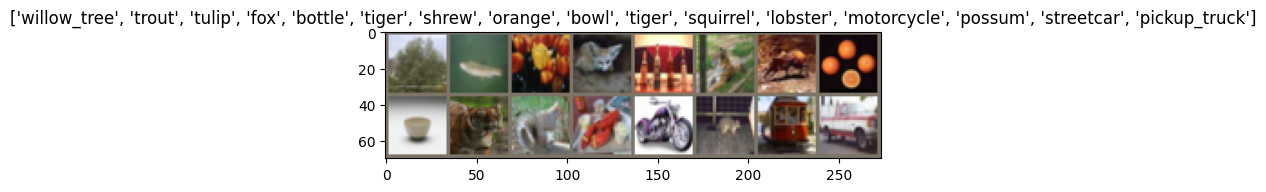

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 16x16

    nn.Conv2d(64, 128, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 8x8

    nn.Conv2d(128, 256, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(256, 256, 3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 4x4

    nn.Conv2d(256, 512, 3, padding=2),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # 2x2

    nn.BatchNorm2d(512),
    nn.Softmax2d(),

    nn.Flatten(),

    nn.Linear(12800, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 100),
)

model = model.float()
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 4.6056 Acc: 0.0090
test Loss: 4.6052 Acc: 0.0100

Epoch 1/99
----------
train Loss: 4.6056 Acc: 0.0089
test Loss: 4.6052 Acc: 0.0100

Epoch 2/99
----------
train Loss: 4.6052 Acc: 0.0091
test Loss: 4.6052 Acc: 0.0100

Epoch 3/99
----------
train Loss: 4.6052 Acc: 0.0098
test Loss: 4.6052 Acc: 0.0100

Epoch 4/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 5/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 6/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 7/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 8/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 9/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 10/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc: 0.0100

Epoch 11/99
----------
train Loss: 4.6052 Acc: 0.0100
test Loss: 4.6052 Acc